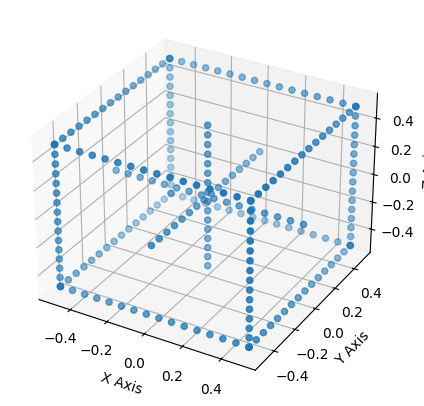

In [3]:
from week1 import box3d, PiInv, Pi,project_points,plot3d
import numpy as np
import matplotlib.pyplot as plt


Exercise 2.1
Reuse the box3d function from last week. Assume that f = 600, α = 1, β = 0, and δx = δy = 400.
Given a traditional camera, what is the resolution in pixels?
Also assume R = I, and t = [0, .2, 1.5]T. Use projectpoints from last week, to project the
points.

In [4]:
#Define the given parameters 

Q = box3d()
f = 600
beta = 0
alpha = 1 
dx = 400
dy = 400

K = np.array([[f,f*beta,dx],[0,alpha*f,dy],[0,0,1]])
R = np.eye(3)
t = np.array([0,0.2,1.5])

#The projected points 
p = project_points(K,R,t,Q)

Are all the points captured by the image sensor?

In [5]:
#The projection matrix 

P = K@np.column_stack((R,t))

P

array([[600. ,   0. , 400. , 600. ],
       [  0. , 600. , 400. , 720. ],
       [  0. ,   0. ,   1. ,   1.5]])

2 x 400 = 800 pixels along each dimensions, i.e. 800 x 800.

Where does the corner P 1 = [−0.5, −0.5, −0.5] project to?


In [6]:
corner = np.array([-0.5,-0.5,-0.5])

project_points(K,R,t,corner)

array([100., 220.])

The corner projects to [100,220].T

#### Create a new or change your function projectpoints to a version that also takes distCoeffs as
#### an input. The list distCoeffs should contain the distortion coefficients [k3, k5, k7, . . . ]. Make the function work for at least 3 coefficients.


In [7]:
def PiInv(coordinate):
    """
    Convert inhomogeneous coordinates to homogeneous coordinates.

    Parameters:
    - coordinate: A numpy array of inhomogeneous coordinates. This can be a 1D array (vector) or a 2D array (matrix).

    Returns:
    - A numpy array of homogeneous coordinates. For a vector, appends a 1 to the end. For a matrix, appends a row of 1s.
    """

    # Handle 1D array (vector) case
    if coordinate.ndim == 1:
        hom = np.append(coordinate, 1)
    # Handle 2D array (matrix) case
    elif coordinate.ndim == 2:
        w = np.ones((1, coordinate.shape[1]))
        hom = np.vstack((coordinate, w))
    else:
        raise ValueError("Input must be a 1D (vector) or 2D (matrix) array.")

    return hom


Exercise 2.1


In [8]:
"""def dist(coef,p):
    powers = np.arange(2,len(coef)*2+1,2)
    p =  Pi(p) 
    r_i = np.sqrt(p[0]**2+p[1]**2)
    delta_r_i =   np.array(coef) *  np.power(r_i,powers)
    p = p * (1+delta_r_i) 

    return p
"""

def dist(coef,p):
    powers = np.arange(2,len(coef)*2+1,2)
    p =  Pi(p) 
    r_i = np.sqrt(p[0]**2+p[1]**2)
    r_i_powers = np.power(r_i.reshape(-1,1)[:,np.newaxis],powers)
    delta_r_i = r_i_powers @ np.array(coef)
    p = p.T * (1+delta_r_i) 

    return p.T


def projectpoint(K,R,t,Q,coef = None ):
    if coef is not None:
        p = np.hstack((R,t.reshape(-1,1))) @ PiInv(Q)
        q = K@PiInv(dist(coef,p))
        return q
    else:
            p = K @ np.column_stack((R,t)) @ PiInv(Q)
            return p


In [9]:
K = np.array([[600,0,400],[0,600,400],[0,0,1]])
R = np.array([[1,0,0],[0,1,0],[0,0,1]])
t = np.array([0,0.2,1.5])
Q = np.array([-0.5,-0.5,-0.5])

projectpoint(K,R,t,Q,[-0.2]).T

array([[120.4 , 232.24,   1.  ]])

Text(0.5, 1.0, 'Unidstorted')

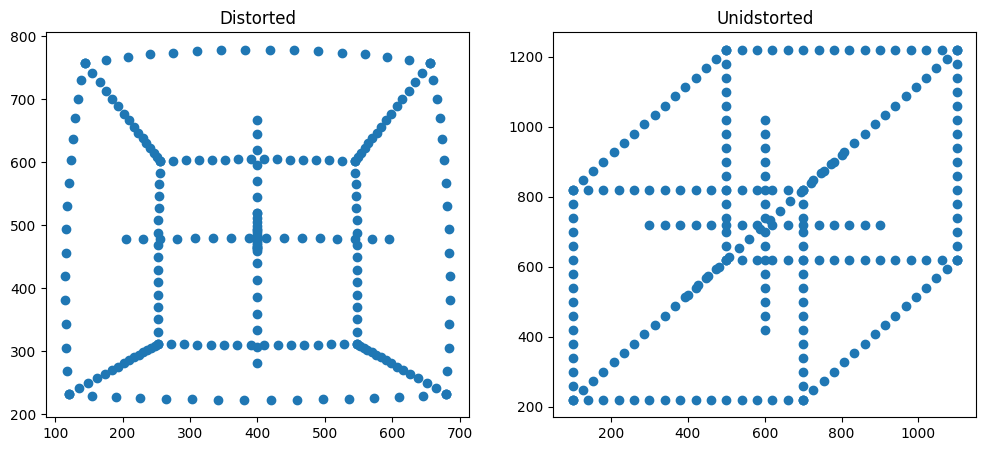

In [10]:
Q = box3d() 
x_d,y_d,_ = (projectpoint(K,R,t,Q))
x_c,y_c,_ = (projectpoint(K,R,t,Q,[-0.2]))


fig,ax = plt.subplots(1,2,figsize=(12,5))


ax[0].scatter(x_c,y_c)
ax[1].scatter(x_d,y_d)


ax[0].set_title("Distorted")
ax[1].set_title("Unidstorted")


Exercise 2.3


In [11]:
import cv2 
im = cv2.imread("gopro_robot.jpg")[:,:,::-1]
im = im.astype(float)/255

f = 0.455732 * im.shape[1]

In [12]:
delta_x = im.shape[1]/2
delta_y = im.shape[0]/2

print(delta_x , delta_y)

960.0 540.0


In [13]:
K = np.array([[f,0,delta_x],[0,f,delta_y],[0,0,1]])


Exercise 2.4


In [14]:
"""
TODO: Validate this function with TA 

"""
def undistortImage(im,K,k):

    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)
    q = np.linalg.inv(K) @ (p)
    q_d = PiInv(dist(k,q))
    p_d = K @ q_d
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)

    return im_undistorted

In [15]:
k = [-0.245031,0.071524,-0.00994978]
undistorted = undistortImage(im,K,k)


Text(0.5, 1.0, 'Original image')

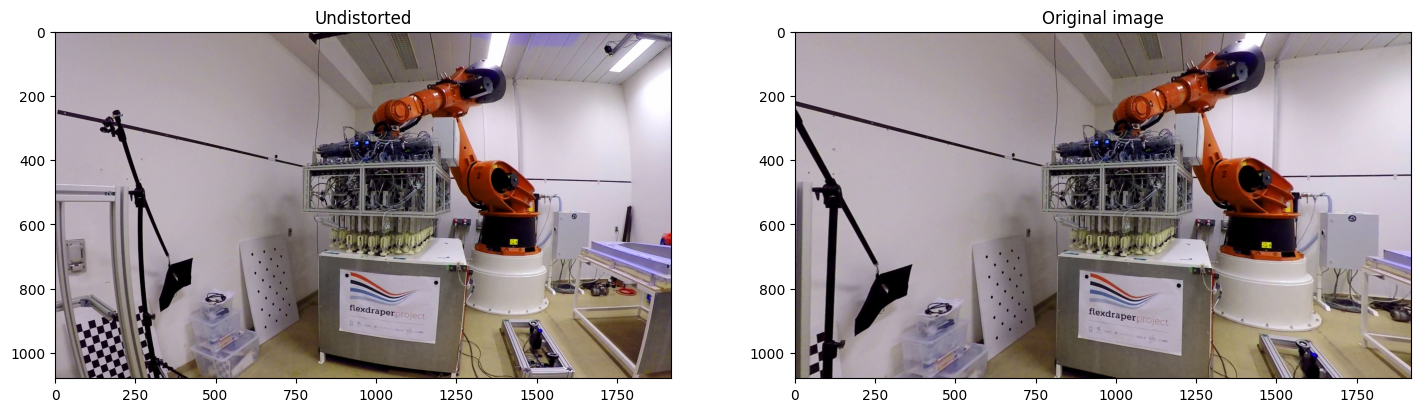

In [16]:
fig,ax = plt.subplots(1,2,figsize=(17.5,10))

ax[1].imshow(undistorted)
ax[0].imshow(im)

ax[0].set_title("Undistorted") 
ax[1].set_title("Original image")

Exercise 2.5


Homographies
Exercise 2.5

In [17]:
import numpy as np
from melon import ComputerVision as mango

p1 = np.array([1,1])
p2 = np.array([0,3]) 
p3 = np.array([2,3])
p4 = np.array([2,4]) 

H = np.array([[-2,0,1],[1,-2,0],[0,0,3]])


q1 = mango.Pi(H@mango.PiInv(p1))
q2 = mango.Pi(H@mango.PiInv(p2))
q3 = mango.Pi(H@mango.PiInv(p3))
q4 = mango.Pi(H@mango.PiInv(p4))


print("The mapped coordinates are: ") 
print(q1,q2,q3,q4)

The mapped coordinates are: 
[-0.33333333 -0.33333333] [ 0.33333333 -2.        ] [-1.         -1.33333333] [-1. -2.]


In [31]:

def smart_transpose(arr):
    """
    Transposes a numpy array.
    - If the array is 1D, it converts it to a 2D column vector.
    - If the array is 2D, it transposes it.
    """
    # If it's a 1D array, reshape it to a 2D column vector
    if arr.ndim == 1:
        return arr.reshape(-1, 1)
    # If it's already 2D, just transpose it
    elif arr.ndim == 2:
        return arr.T
    # For arrays with more dimensions, you might need a more specific handling
    else:
        raise ValueError("Array with more than 2 dimensions are not supported.")


"""def hest(q1,q2):


    q11 = np.array([[0,-1,q1[1]],[1,0,-q1[0]],[-q1[1],q1[0],0]])
    B = np.kron(PiInv(q2).reshape(1,3),q11)
    U,S,VT = np.linalg.svd(B)
    H = VT[-1,:].reshape(3,3).T
    return H""" 


def hest(q1,q2):
    


   # q1_ix = [crossOp(q_i) for q_i in q1.T]
    B = None 


    for q1_i,q2_i in zip(q1.T,q2.T):

        if B is not None: 
            B = np.vstack((B,np.kron(q2_i, mango.crossOp(q1_i)) ))
        else:
            B = np.kron((q2_i), mango.crossOp(q1_i))

    U,S,VT = np.linalg.svd(B)
   
    H = VT[-1,:].reshape(3,3).T

    return H




In [32]:
P = mango.PiInv(np.array([p1,p2,p3,p4]).T)
q = mango.PiInv(np.array([q1,q2,q3,q4]).T)

H = hest(q,P)


In [33]:
Pi(H @ P)

array([[-0.33333333,  0.33333333, -1.        , -1.        ],
       [-0.33333333, -2.        , -1.33333333, -2.        ]])

In [29]:
q

array([[-0.33333333,  0.33333333, -1.        , -1.        ],
       [-0.33333333, -2.        , -1.33333333, -2.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [22]:
t_ = np.array([2,3,4]) 
t_.shape

(3,)

In [23]:
smart_transpose(t_).shape

(3, 1)

In [24]:
p1.ndim

1

In [25]:
q1.shape

(2,)

In [26]:
p1.shape

(2,)

In [27]:
F = hest(Pi(H@PiInv(p1)),p1) 

q1 = Pi(F@PiInv(p1))
q2 = Pi(F@PiInv(p2))
q3 = Pi(F@PiInv(p3))
q4 = Pi(F@PiInv(p4))

print("The mapped coordinates are: ") 
Matrix(q1), Matrix(q2),Matrix(q3),Matrix(q4)



IndexError: invalid index to scalar variable.

Exercise 2.7


In [ ]:
def normalize2d(p):
    mu = np.mean(p,axis=1) 
    mu_x = mu[0]
    mu_y = mu[1] 

    sd = np.std(p,axis=1)
    sd_x = sd[0]
    sd_y = sd[1]    

    T_inv = np.array([[sd_x,0,mu_x],[0,sd_y,mu_y],[0,0,1]])
    T = np.linalg.inv(T_inv)

    return T 

In [ ]:
point_test = np.array([[2,4,2],[6,8,4]])
T = normalize2d(point_test)

normalized = Pi(T@PiInv(point_test)) 

np.mean(normalized,axis=1)
np.std(normalized,axis=1)

array([1., 1.])

Exercise 2.8
Improve your hest function by adding an option (normalize=true/false) to normalize the points


In [ ]:
#TODO: Validate with TA 

def hest(q1,q2,normalize=False):


    if normalize:
        T = normalize2d(np.column_stack((q1,q2)))
        q1 = Pi(T@PiInv(q1))
        q2 = Pi(T@PiInv(q2))

    B= None 


    #Check if shapes are equal 

    if q1.shape != q2.shape:

        raise ValueError(f"The two coordinates q1 and q2 must be of the same shape, but got q1 shape: {q1.shape} and q2 shape: {q2.shape}.")
    

    #Case 1 : single coordinate
    
    if q1.ndim == 1:
            
            q11 = np.array([[0,-1,q1[1]],[1,0,-q1[0]],[-q1[1],q1[0],0]])
            B = np.kron(PiInv(q2),q11)
    #Case 2 : multiple coordinates 

    if q1.ndim > 1:

        for q1_i,q2_i in zip(q1.T,q2.T):

            q1_i = np.array([[0,-1,q1_i[1]],[1,0,-q1_i[0]],[-q1_i[1],q1_i[0],0]])

            if B is not None:
                B = np.vstack((B,np.kron(PiInv(q2_i).T,q1_i)))
            else:
                B = np.kron(PiInv(q2_i).T,q1_i)


    #B = np.kron(PiInv(q2).reshape(1,3),q11)
    U,S,VT = np.linalg.svd(B)
    H = VT[-1,:].reshape(3,3).T

    if normalize: 
        H = T @ H
    return H




In [ ]:
%matplotlib inline 

## Exercise 2.9
* Generate 100 random 2D points, and a random homography. Map the points using the homogra-
phy, and use hest to estimate the homography from the points. 

In [ ]:
q2 = np.random.randn(2, 100)
q2h = np.vstack((q2, np.ones((1, 100))))
H_true = np.random.randn(3,3)
q1h = H_true@q2h
q1 = Pi(q1h)

In [ ]:
H = hest(q1,q2,False)

np.testing.assert_almost_equal(Pi(H_true @ q2h),Pi(H @ q2h))

In [ ]:
import matplotlib
matplotlib.use('TkAgg')



In [ ]:
import matplotlib.pyplot as plt 

A  = cv2.imread('A.jpeg')[:,:,::-1].astype(float)/255
B = cv2.imread('B.jpeg')[:,:,::-1].astype(float)/255

fig,ax = plt.subplots(1,2,figsize=(8,8))

ax[0].imshow(A)
ax[1].imshow(B)

x = plt.ginput(8)

plt.show()

In [ ]:
p1,p2,p3,p4,q1,q2,q3,q4 = x

In [ ]:
p1 = np.array([p1,p2,p3,p4]).T
p2 = np.array([q2,q2,q3,q4]).T

In [ ]:
H_img = hest(p2,p1)

In [ ]:
Pi(H_img @ PiInv(p1).astype(int))

array([[ 571.62129032,  571.62129033,  571.62129035,  571.62128943],
       [1575.05935484, 1575.05935485, 1575.05935547, 1575.05935293]])

In [ ]:
p2

array([[ 571.62129032,  571.62129032,  836.04709677,  518.73612903],
       [1575.05935484, 1575.05935484, 1332.66903226, 1151.97806452]])

In [ ]:
def warpImage(im, H):
    imWarp = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
    return imWarp

In [ ]:
generated = warpImage(B,H_img)

In [ ]:
3+3

In [ ]:
plt.close()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.11/tkinter/__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/matplotlib/backends/_backend_tk.py", line 512, in destroy
    Gcf.destroy(self)
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 66, in destroy
    manager.destroy()
  File "/usr/lib/python3/dist-packages/matplotlib/backends/_backend_tk.py", line 547, in destroy
    delayed_destroy()
  File "/usr/lib/python3/dist-packages/matplotlib/backends/_backend_tk.py", line 537, in delayed_destroy
    self.window.destroy()
  File "/usr/lib/python3.11/tkinter/__init__.py", line 2368, in destroy
    self.tk.call('destroy', self._w)
_tkinter.TclError: can't invoke "destroy" command: application has been destroyed
Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.11/tkinter/__init__.py", line 1948, in __cal